In [1]:
!pip -q install "transformers>=4.41.0" "datasets>=2.19.0" "accelerate>=0.33.0" einops bitsandbytes matplotlib scikit-learn

In [2]:
import torch, platform
print("torch:", torch.__version__, "cuda:", torch.version.cuda, "cuda available:", torch.cuda.is_available())
!nvidia-smi -L

torch: 2.6.0+cu124 cuda: 12.4 cuda available: True
GPU 0: Tesla T4 (UUID: GPU-91555a4c-57fc-512e-65b2-5a8db4bf967e)
GPU 1: Tesla T4 (UUID: GPU-b732d92f-a75e-0eb5-ad77-a9803943b484)


In [3]:
import os, math, random, torch, numpy as np, pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from collections import Counter, defaultdict

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"   # I used T4, it should be sufficient
DEVICE

'cuda'

In [5]:
MODEL_ID = "Qwen/Qwen3-0.6B"   # bc it's small and not gated

In [6]:
# answer should be exactly one letter (one token)
SYS = "Answer with a single capital letter only: A, B, C, or D. Do not explain."

In [7]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type="nf4",
                                bnb_4bit_compute_dtype=torch.bfloat16)   # quantization

In [8]:
tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tok.pad_token = tok.eos_token

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",   # safest for colab, can use "cuda" if you're sure the model fits on one gpu
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
model.eval();

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [11]:
# using QA ARC-easy dataset (bc the model is small) + I want to get prob of exactly one token for simplicity

arc = load_dataset("ai2_arc", "ARC-Easy")
train_raw, val_raw = arc["train"], arc["validation"]

README.md: 0.00B [00:00, ?B/s]

ARC-Easy/train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

ARC-Easy/test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

ARC-Easy/validation-00000-of-00001.parqu(…):   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

In [12]:
pd.DataFrame(val_raw).head()

,id,question,choices,answerKey
0,MCAS_2000_4_6,Which technology was developed most recently?,"{'text': ['cellular telephone', 'television', ...",A
1,Mercury_7057260,A student hypothesizes that algae are producer...,"{'text': ['Do algae consume other organisms?',...",C
2,ACTAAP_2014_7_6,Soccer players use their muscle systems to kic...,"{'text': ['The nervous system', 'The endocrine...",A
3,Mercury_7122448,Planets in the solar system are in constant mo...,"{'text': ['the size of the planets', 'gravitat...",B
4,Mercury_SC_416516,How is a pond different from a lake?,"{'text': ['Ponds have moving water.', 'Ponds a...",B


In [13]:
val_raw[0]

{'id': 'MCAS_2000_4_6',
 'question': 'Which technology was developed most recently?',
 'choices': {'text': ['cellular telephone',
   'television',
   'refrigerator',
   'airplane'],
  'label': ['A', 'B', 'C', 'D']},
 'answerKey': 'A'}

In [14]:
def four_choice(ex):
    '''Additional sanity check. Not necessary for ARC-easy, just to feel safe'''
    labels = ex["choices"]["label"]
    return labels is not None and sorted(labels) == ["A", "B", "C", "D"]


def mc_prompt(ex):   # MC = multiple-choice
    '''Creates a prompt from each dataset entry'''
    q = str(ex["question"]).strip()
    labels = [str(L).strip().upper() for L in ex["choices"]["label"]]
    texts  = [str(t).strip() for t in ex["choices"]["text"]]
    # map {label: text}
    m = {L: t for L, t in zip(labels, texts)}

    return (
        f"{SYS}\n\n"
        f"Question: {q}\n"
        f"Options:\n"
        f"A. {m['A']}\n"
        f"B. {m['B']}\n"
        f"C. {m['C']}\n"
        f"D. {m['D']}\n\n"
        f"Answer: "   # trailing space after 'Answer:' helps next-token scoring (ensures the next token is a word)
    )


def correct_letter(ex):
    '''Also a bit redundant, just to make sure there are no accidental spaces left,
    bc we need very robust and clear embedding'''
    return ex["answerKey"].strip()


# log-probability of answering with a given letter (robust to tokenizer quirks)
@torch.inference_mode()
def string_logprob_for_letter(prompt_ids, letter):
    """
    Compute log P(letter | prompt), robustly considering possible tokenization of 'A' vs ' A'.
    Falls back to multi-token continuation if needed.
    """
    candidates = [letter, " " + letter]   # again, just in case the tokenizer took a space from the answer
    cand_log_probs = []
    for cand in candidates:
        cand_ids = tok(cand, add_special_tokens=False).input_ids   # tokenization
        if not cand_ids:
            continue
        # concatenate prompt + candidate and run one forward
        x = torch.tensor(prompt_ids + cand_ids).unsqueeze(0).to(model.device)  # move tensor to the model's device
        out = model(input_ids=x)
        logits = out.logits[0]   # [len_of_sequence, vocab_size]
        T_prompt = len(prompt_ids)   # len of the prompt (number of tokens)
        lp = 0.0
        for t, tok_id in enumerate(cand_ids):
            lp_t = torch.log_softmax(logits[T_prompt - 1 + t], dim=-1)[tok_id].item()   # log-probs
            lp += lp_t
        cand_log_probs.append(lp)
    return max(cand_log_probs)   # higher log-prob between a letter and a (space+letter) -> a more probable encoding


@torch.inference_mode()
def letter_logprobs(prompt_text):
    enc = tok(prompt_text, return_tensors="pt", add_special_tokens=False)
    input_ids = enc["input_ids"][0].tolist()
    letters = ["A", "B", "C", "D"]
    return {L: string_logprob_for_letter(input_ids, L) for L in letters}


def mc_entropy(letter_logprobs):
    # letter_logprobs: dict like {'A': lpA, 'B': lpB, ...} (natural logs)
    lps = list(letter_logprobs.values())
    m = max(lps)
    Z = sum(math.exp(lp - m) for lp in lps)   # stabilized partition sum (makes sure ps sums to 1)
    ps = [math.exp(lp - m) / Z for lp in lps]   # normalized probs
    return -sum(p * math.log(p + 1e-12) for p in ps)  # Shannon enthropy


# evaluate: p_correct, p_wrong_max, log-prob margin; keep correctness flag
def score_split(examples):
    records = []
    for ex in examples:
        prompt = mc_prompt(ex)
        lps = letter_logprobs(prompt)  # dict: letter -> log p(letter | prompt)
        corr = correct_letter(ex)
        pred = max(lps.items(), key=lambda kv: kv[1])[0]
        # probabilities from log-probs
        lp_correct = lps[corr]
        p_correct = float(np.exp(lp_correct))
        wrong_best_lp = max([lp for L, lp in lps.items() if L != corr], default=-1e30)
        p_wrong_max = float(np.exp(wrong_best_lp))
        margin = float(lp_correct - wrong_best_lp)  # log-prob margin

        records.append({
            "prompt": prompt,
            "correct": corr,
            "pred": pred,
            "is_correct": int(pred == corr),
            "p_correct": p_correct,
            "p_wrong_max": p_wrong_max,
            "logprob_margin": margin,
        })
    return records


# keep only correct items, then split by percentile tails of the margin
def percentile_split_correct(scored, low_q=0.3, high_q=0.7):
    correct = [r for r in scored if r["is_correct"] == 1]
    if len(correct) < 10:
        raise ValueError("Too few correct items; increase sample size or use a larger split.")
    margins = np.array([r["logprob_margin"] for r in correct], dtype=np.float64)
    lo, hi = np.quantile(margins, [low_q, high_q])
    low  = [r for r in correct if r["logprob_margin"] <= lo]
    high = [r for r in correct if r["logprob_margin"] >= hi]
    return correct, low, high, (lo, hi)


def summarize(name, scored, correct, low, high, lo, hi):
    acc = sum(r["is_correct"] for r in scored) / max(1, len(scored))
    print(f"{name}: n={len(scored)} | accuracy={acc:.3f}")
    print(f"  correct n={len(correct)} | low={len(low)} (≤ {lo:.3f}) | high={len(high)} (≥ {hi:.3f})")
    # a few example margins
    ms = np.array([r["logprob_margin"] for r in correct], dtype=np.float64)
    print(f"  margin stats on correct: mean={ms.mean():.3f}, std={ms.std():.3f}, "
          f"min={ms.min():.3f}, 25%={np.quantile(ms,0.25):.3f}, 50%={np.quantile(ms,0.5):.3f}, "
          f"75%={np.quantile(ms,0.75):.3f}, max={ms.max():.3f}")

In [15]:
train = [ex for ex in train_raw if four_choice(ex)]
val   = [ex for ex in val_raw   if four_choice(ex)]

In [16]:
# downsample for speed in Colab (can be skipped)
random.seed(42)
train = random.sample(train, k=min(400, len(train)))
val   = random.sample(val,   k=min(200, len(val)))

In [17]:
train_scored = score_split(train)
val_scored   = score_split(val)

train_correct, train_low, train_high, (train_lo, train_hi) = percentile_split_correct(train_scored, 0.3, 0.7)
val_correct,   val_low,   val_high,   (val_lo,   val_hi)   = percentile_split_correct(val_scored,   0.3, 0.7)

In [18]:
# --- Quick summary
summarize("TRAIN", train_scored, train_correct, train_low, train_high, train_lo, train_hi)
summarize("VALID", val_scored,   val_correct,   val_low,   val_high,   val_lo,   val_hi)
# only correct answers are considered further, so low accuracy is fine, but the dataset will be about twice as small

TRAIN: n=400 | accuracy=0.505
  correct n=202 | low=62 (≤ 1.375) | high=62 (≥ 3.244)
  margin stats on correct: mean=2.440, std=1.566, min=0.125, 25%=1.126, 50%=2.248, 75%=3.498, max=8.363
VALID: n=200 | accuracy=0.500
  correct n=100 | low=30 (≤ 1.001) | high=30 (≥ 2.997)
  margin stats on correct: mean=2.200, std=1.663, min=0.000, 25%=0.875, 50%=1.936, 75%=3.402, max=6.881


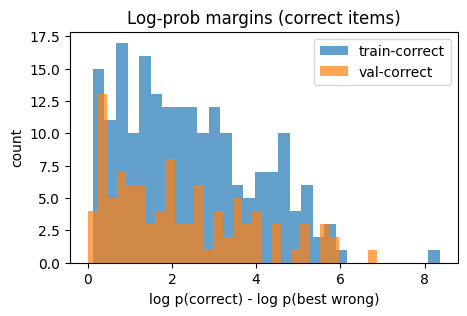

In [19]:
# histogram of margins for correct items
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5,3))
    plt.hist([r["logprob_margin"] for r in train_correct], bins=30, alpha=0.7, label="train-correct")
    plt.hist([r["logprob_margin"] for r in val_correct],   bins=30, alpha=0.7, label="val-correct")
    plt.title("Log-prob margins (correct items)")
    plt.xlabel("log p(correct) - log p(best wrong)")
    plt.ylabel("count")
    plt.legend()
    plt.show()
except Exception as e:
    print("Histogram skipped:", e)

In [20]:
val_scored[0]

{'prompt': 'Answer with a single capital letter only: A, B, C, or D. Do not explain.\n\nQuestion: When the roller coaster rolls onto a flat section of track, what force would ultimately bring it to a stop if no other forces are added?\nOptions:\nA. gravity\nB. weight\nC. friction\nD. acceleration\n\nAnswer: ',
 'correct': 'C',
 'pred': 'D',
 'is_correct': 0,
 'p_correct': 0.050571100611906464,
 'p_wrong_max': 0.29101659090983195,
 'logprob_margin': -1.75}

In [21]:
train_scored[-1]

{'prompt': 'Answer with a single capital letter only: A, B, C, or D. Do not explain.\n\nQuestion: In Costa Rica a small tree, the acacia, provides shelter and food for ants. The ants protect the acacia by removing other insects and vines that might harm it. Which term best describes the relationship between the acacia and the ants?\nOptions:\nA. competition\nB. mutualism\nC. parasitism\nD. predation\n\nAnswer: ',
 'correct': 'B',
 'pred': 'D',
 'is_correct': 0,
 'p_correct': 0.019496896108597995,
 'p_wrong_max': 0.5675614520150244,
 'logprob_margin': -3.37109375}

In [22]:
# a small sanity check

def _logsumexp(vals):   # for stability
    m = max(vals)
    return m + math.log(sum(math.exp(v - m) for v in vals))

@torch.inference_mode()
def compute_label_free_conf(scored):
    """
    For each record (with .prompt already in it), recompute option log-probs
    and return label-free confidence stats: top1-top2 gap and p_top1.
    """
    out = []
    for r in scored:
        lps = letter_logprobs(r["prompt"])             # dict: letter -> log p
        items = sorted(lps.items(), key=lambda kv: kv[1], reverse=True)
        (predL, lp1), (_, lp2) = items[0], items[1]
        lse = _logsumexp([lp for _, lp in items])
        p_top1 = math.exp(lp1 - lse)
        out.append({"gap": lp1 - lp2, "p_top1": p_top1, "is_correct": r["is_correct"]})
    return out

def binned_acc_on(records, key="gap", nbins=10, return_points=False):
    '''
    If confidence makes sense, it should increase along with increasing accuracy.
    Logic: if the model "knows" the answer, it outpits that answer right away and will likely be correct.
    Otherwise it will take a guess and will get more wrong answers, getting closer to random guess.
    '''
    xs = np.array([r[key] for r in records], float)
    ys = np.array([r["is_correct"] for r in records], int)
    edges = np.quantile(xs, np.linspace(0,1,nbins+1))   # equal-mass bins
    mids, accs, ns = [], [], []
    for i in range(nbins):
        mask = (xs>=edges[i]) & (xs<=edges[i+1] if i==nbins-1 else xs<edges[i+1])
        if mask.sum()>0:
            mids.append(xs[mask].mean())
            accs.append(ys[mask].mean())
            ns.append(mask.sum())
    print(f"Accuracy by {key} bins:", [round(a, 2) for a in accs])
    return (np.array(mids), np.array(accs), np.array(ns)) if return_points else None


train_conf = compute_label_free_conf(train_scored)
val_conf   = compute_label_free_conf(val_scored)

binned_acc_on(train_conf, key="gap")
binned_acc_on(val_conf,   key="gap")
binned_acc_on(train_conf, key="p_top1")
binned_acc_on(val_conf,   key="p_top1")
# all generally increase with dips in the beginning, but it looks like confidence is a real thing

Accuracy by gap bins: [0.11, 0.3, 0.38, 0.43, 0.36, 0.4, 0.62, 0.72, 0.75, 0.9]
Accuracy by gap bins: [0.4, 0.46, 0.29, 0.1, 0.5, 0.5, 0.55, 0.65, 0.65, 0.85]
Accuracy by p_top1 bins: [0.18, 0.28, 0.42, 0.38, 0.3, 0.5, 0.62, 0.72, 0.72, 0.92]
Accuracy by p_top1 bins: [0.3, 0.5, 0.2, 0.25, 0.45, 0.5, 0.6, 0.7, 0.7, 0.8]


Accuracy by gap bins: [0.39, 0.38, 0.15, 0.52, 0.43, 0.67, 0.64, 0.8]


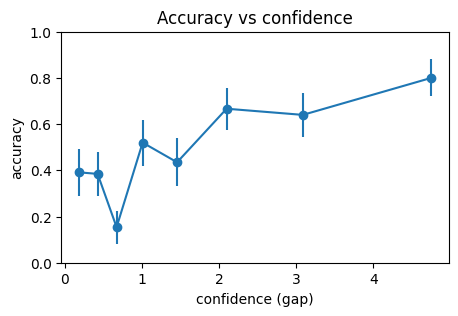

In [23]:
# plot for val_conf
m,a,n = binned_acc_on(val_conf, key="gap", nbins=8, return_points=True)
se = np.sqrt(a*(1-a)/np.maximum(n,1))
plt.figure(figsize=(5,3))
plt.errorbar(m, a, yerr=se, fmt='o-')
plt.xlabel("confidence (gap)"); plt.ylabel("accuracy")
plt.ylim(0,1); plt.title("Accuracy vs confidence"); plt.show()

In [24]:
val_conf[0]

{'gap': 0.625, 'p_top1': 0.5469058326002219, 'is_correct': 0}

In [30]:
# extract a "certainty direction" with difference-of-means and pick a layer
def _last_positions(attn_mask):
    '''
    Helper: last prompt position (where generation would start)
    '''
    return attn_mask.sum(dim=1) - 1  # [N]

@torch.inference_mode()
def collect_layer_activations_from_prompts(prompts, batch_size=8, max_len=1024):
    """
    Returns tensor [L, N, d]: per-layer hidden state at the last prompt token for each prompt. That is the representation right before the model answers
    Works with device_map='auto' (keep inputs on CPU; Accelerate routes as needed).
    L is the number of layers;
    N is the number of prompts;
    d is the embedding dimension.
    """
    all_blocks = None
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]   # processing prompts in batches for speed
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_len, add_special_tokens=False)
        # Move input tensors to the model's device
        enc = {k: v.to(model.device) for k, v in enc.items()}
        out = model(**enc, output_hidden_states=True, use_cache=False)   # fwd pass
        hs = out.hidden_states                 # tuple: [emb, layer1, ..., layerL]
        L = len(hs) - 1   # the number of transformer layers
        pos = _last_positions(enc["attention_mask"])  # [B]
        # gather per-layer states at last prompt token
        stk = []
        for l in range(1, L+1):
            h = hs[l]  # [B, T, d]
            picked = h[torch.arange(h.shape[0], device=model.device), pos]  # [B, d]
            stk.append(picked)
        block = torch.stack(stk, dim=0)  # [L, B, d]
        all_blocks = block if all_blocks is None else torch.cat([all_blocks, block], dim=1)   # stack all layers
    return all_blocks  # [L, N, d] (dtype = model dtype, device = mixed under the hood)

In [31]:
# Build prompt lists from scored records
train_high_prompts = [r["prompt"] for r in train_high]   # train, high conf
train_low_prompts  = [r["prompt"]  for r in train_low]   # train, low conf
val_high_prompts   = [r["prompt"]  for r in val_high]   # val, high conf
val_low_prompts    = [r["prompt"]  for r in val_low]   # val, low conf

# Collect activations for training set with high vs low confidence
Hh_train = collect_layer_activations_from_prompts(train_high_prompts)   # [L - num of layers, Nh - num of examples, d - vector dim in layer]
Hl_train = collect_layer_activations_from_prompts(train_low_prompts)    # [L, Nl, d]

# Difference of means per layer
# centroids of high-conf and low-conf activations
mu_high = Hh_train.mean(dim=1)                    # [L, d]
mu_low = Hl_train.mean(dim=1)                    # [L, d]
# difference of means vector (exactly like in the refusal paper)
R = (mu_high - mu_low)                      # [L, d]
R_hat = F.normalize(R.float(), dim=1)           # unit vector per layer (normalized across layers)

In [32]:
val_high_prompts[0]

'Answer with a single capital letter only: A, B, C, or D. Do not explain.\n\nQuestion: Camels have humps on their backs that store fat, allowing them to survive for many days without food. This makes camels well suited to desert life. This characteristic is an example of\nOptions:\nA. adaptation.\nB. instinct.\nC. migration.\nD. hibernation.\n\nAnswer: '

In [33]:
Hh_train[0]

tensor([[ 0.2129, -0.4141,  0.0474,  ..., -0.1318,  0.0811,  0.0566],
        [ 0.2539, -0.4355,  0.0439,  ..., -0.1416,  0.0718,  0.0488],
        [ 0.2266, -0.4238,  0.0371,  ..., -0.1396,  0.0757,  0.0601],
        ...,
        [ 0.2432, -0.4023,  0.0298,  ..., -0.1172,  0.0398,  0.0417],
        [ 0.2168, -0.4121,  0.0476,  ..., -0.1396,  0.0732,  0.0640],
        [ 0.2559, -0.4160,  0.0305,  ..., -0.1172,  0.0864,  0.0884]],
       device='cuda:1', dtype=torch.bfloat16)

In [34]:
mu_high, mu_low, R, R_hat

(tensor([[ 2.4219e-01, -4.1602e-01,  2.8564e-02,  ..., -1.2793e-01,
           6.4941e-02,  6.4453e-02],
         [ 2.3535e-01, -3.3008e-01,  6.6406e-02,  ..., -8.1543e-02,
          -2.0142e-02,  2.0020e-01],
         [ 3.3984e-01, -1.8750e-01,  4.4678e-02,  ..., -2.6367e-01,
           1.5747e-02,  2.0215e-01],
         ...,
         [ 1.8594e+00, -7.9688e-01,  1.9000e+02,  ..., -1.5875e+01,
           2.2188e+00,  3.9375e+00],
         [-2.3594e+00,  1.1133e-01,  2.2900e+02,  ..., -1.6875e+01,
          -2.7031e+00,  1.6172e+00],
         [-1.3047e+00,  1.0250e+01, -8.6719e-01,  ..., -5.4375e+00,
          -1.7734e+00,  2.0938e+00]], device='cuda:1', dtype=torch.bfloat16),
 tensor([[ 2.4023e-01, -4.1797e-01,  2.8564e-02,  ..., -1.2793e-01,
           6.4453e-02,  6.3477e-02],
         [ 2.3730e-01, -3.3594e-01,  6.6406e-02,  ..., -7.7637e-02,
          -1.8188e-02,  1.9922e-01],
         [ 3.3398e-01, -1.9531e-01,  4.7363e-02,  ..., -2.5586e-01,
           1.8799e-02,  1.9531e-01],


[Direction] Chosen layer = 21 (within first 80%), val cosine-margin = 0.060


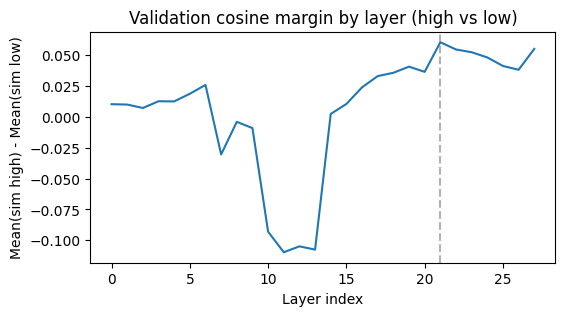

[Sanity] Spearman(cosine, logprob margin) on val-correct: rho=0.342, p=0.000496


In [35]:
# Validate layers on held-out (val) using cosine margin: mean(sim(high)) - mean(sim(low))
@torch.inference_mode()
def cosine_margin_on(prompts_high, prompts_low, R_hat):
    '''
    Difference of mean similarities; shows if there is separation between two groups
    '''
    Hh = collect_layer_activations_from_prompts(prompts_high)  # [L, Nh, d]
    Hl = collect_layer_activations_from_prompts(prompts_low)   # [L, Nl, d]
    Hh_n = F.normalize(Hh.float(), dim=2)
    Hl_n = F.normalize(Hl.float(), dim=2)
    Rh   = R_hat.unsqueeze(1)                                   # [L, 1, d]
    sim_h = (Hh_n * Rh).sum(dim=2).mean(dim=1)                  # [L]
    sim_l = (Hl_n * Rh).sum(dim=2).mean(dim=1)                  # [L]
    return (sim_h - sim_l)                                      # [L]

val_margin = cosine_margin_on(val_high_prompts, val_low_prompts, R_hat)

# Choose the best layer **within the first 80%** (avoid wording/unembedding layers)
num_layers = R_hat.shape[0]
cut = int(math.floor(0.8 * num_layers))
best_layer = int(val_margin[:cut].argmax().item())

print(f"[Direction] Chosen layer = {best_layer} (within first 80%), "
      f"val cosine-margin = {val_margin[best_layer].item():.3f}")

# visualize margin by layer
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.plot(val_margin.cpu().tolist())
    plt.axvline(cut-1, ls="--", color="gray", alpha=0.6)
    plt.title("Validation cosine margin by layer (high vs low)")
    plt.xlabel("Layer index")
    plt.ylabel("Mean(sim high) - Mean(sim low)")
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

# sanity: does r·h correlate with *continuous* logprob margin on val-correct?
val_correct = [r for r in val_scored if r["is_correct"] == 1]
val_corr_prompts = [r["prompt"] for r in val_correct]
val_margins      = np.array([r["logprob_margin"] for r in val_correct], dtype=np.float64)

@torch.inference_mode()
def cosine_scores(prompts, layer, rhat):
    H = collect_layer_activations_from_prompts(prompts)  # [L, N, d]
    h = F.normalize(H.float(), dim=2)[layer]             # [N, d]
    r = rhat[layer].unsqueeze(0)                         # [1, d]
    return (h * r).sum(dim=1).cpu().numpy()              # [N]

try:
    scores = cosine_scores(val_corr_prompts, best_layer, R_hat)
    # Spearman rank corr without extra deps (fallback if scipy absent)
    try:
        rho, p = spearmanr(scores, val_margins)
        print(f"[Sanity] Spearman(cosine, logprob margin) on val-correct: rho={rho:.3f}, p={p:.3g}")
    except Exception:
        # simple rank-corr via numpy
        def _rankdata(a):
            temp = a.argsort()
            ranks = np.empty_like(temp, dtype=float)
            ranks[temp] = np.arange(len(a))
            return ranks
        rr = np.corrcoef(_rankdata(scores), _rankdata(val_margins))[0,1]
        print(f"[Sanity] Spearman approx (no scipy): rho≈{rr:.3f}")
except Exception as e:
    print("Continuous-margin sanity check skipped:", e)

There is a statistically significant moderate positive correlation between projection into certainty direction and the log=prob margin (p<0.05)

In [36]:
val_margin   # margin by layers, spikes at layer 21; the difference looks significant
# means that certainty separates values on unseen data

tensor([ 0.0101,  0.0098,  0.0070,  0.0125,  0.0123,  0.0185,  0.0257, -0.0305,
        -0.0042, -0.0092, -0.0930, -0.1096, -0.1048, -0.1075,  0.0022,  0.0103,
         0.0237,  0.0328,  0.0355,  0.0404,  0.0362,  0.0602,  0.0543,  0.0521,
         0.0479,  0.0410,  0.0379,  0.0548], device='cuda:1')

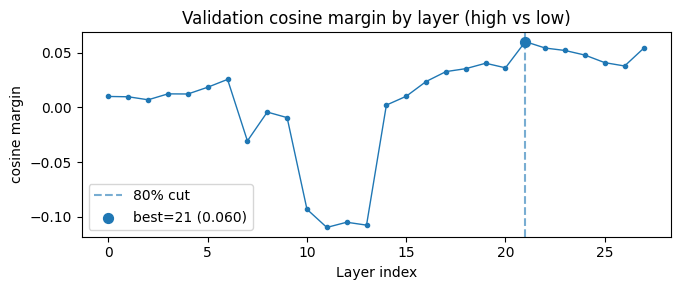

Best layer (<=80%): 21, margin=0.0602


In [37]:
vm = val_margin.detach().float().cpu().numpy()
L = len(vm)
cut = int(0.8 * L)                 # first 80% of layers
best = int(np.argmax(vm[:cut]))    # best layer within the allowed range

plt.figure(figsize=(7,3))
plt.plot(vm, marker='o', ms=3, lw=1)
plt.axvline(cut-1, ls='--', alpha=0.6, label='80% cut')
plt.scatter([best], [vm[best]], s=50, zorder=3, label=f'best={best} ({vm[best]:.3f})')
plt.title('Validation cosine margin by layer (high vs low)')
plt.xlabel('Layer index')
plt.ylabel('cosine margin')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best layer (<=80%): {best}, margin={vm[best]:.4f}")

In [38]:
# sanity check
def layer_scores(prompts, layer, rhat):
    H = collect_layer_activations_from_prompts(prompts)  # [L,N,d]
    h = F.normalize(H.float(), dim=2)[layer]             # [N,d]
    r = rhat[layer].unsqueeze(0)
    return (h*r).sum(dim=1).cpu().numpy()

bh = layer_scores(val_high_prompts, best_layer, R_hat)
bl = layer_scores(val_low_prompts,  best_layer, R_hat)
d  = (bh.mean()-bl.mean()) / np.sqrt(0.5*(bh.var(ddof=1)+bl.var(ddof=1)))  # Cohen's d (standardized effect size)
print("Cohen d =", round(d,3))   # 0.2 is a small effect, 0.5 is medium, 0.8 is large, 1.2 is very large (from Wikipedia)

Cohen d = 0.9


It looks like there is indeed some "certainty direction", that separates high vs low confidence quite well, at least for a small Qwen model I used

In [39]:
# conf intervals - even more checks

bh = cosine_scores(val_high_prompts, best_layer, R_hat)  # high-confidence val
bl = cosine_scores(val_low_prompts,  best_layer, R_hat)  # low-confidence val

def cohen_d(a,b):
    return (a.mean()-b.mean())/np.sqrt(0.5*(a.var(ddof=1)+b.var(ddof=1)))

def bootstrap_ci(a,b,B=2000,seed=0):
    rng=np.random.default_rng(seed); d=[]
    n1,n2=len(a),len(b)
    for _ in range(B):
        s1=a[rng.integers(0,n1,n1)]; s2=b[rng.integers(0,n2,n2)]
        d.append(cohen_d(s1,s2))
    return np.percentile(d,[2.5,50,97.5])

lo,med,hi = bootstrap_ci(bh,bl)
print(f"Cohen d bootstrap 95% CI: [{lo:.2f}, {hi:.2f}]  (median {med:.2f})")   # looks robust

Cohen d bootstrap 95% CI: [0.44, 1.46]  (median 0.92)


In [40]:
# Try 25/75 instead of 30/70, recompute direction on TRAIN, evaluate on VAL
# as an additional check

def tails(scored, low_q, high_q):
    corr = [r for r in scored if r["is_correct"]==1]
    ms = np.array([r["logprob_margin"] for r in corr], float)
    lo,hi = np.quantile(ms,[low_q, high_q])
    low  = [r["prompt"] for r in corr if r["logprob_margin"]<=lo]
    high = [r["prompt"] for r in corr if r["logprob_margin"]>=hi]
    return low, high


train_low25, train_high75 = tails(train_scored, 0.25, 0.75)
Hh = collect_layer_activations_from_prompts(train_high75)
Hl = collect_layer_activations_from_prompts(train_low25)
R2 = (Hh.mean(dim=1) - Hl.mean(dim=1)).float()
R2_hat = torch.nn.functional.normalize(R2, dim=1)

vm2 = cosine_margin_on(val_high_prompts, val_low_prompts, R2_hat)
cut = int(0.8*R2_hat.shape[0]); best2 = int(vm2[:cut].argmax().item())
print("Alt split best layer:", best2, " val margin:", vm2[best2].item())   # still layer 21 (that's good)

Alt split best layer: 21  val margin: 0.06224938482046127


In [41]:
# testing alignment between the two curves

vm1 = val_margin.detach().float().cpu().numpy()            # from the first fit
vm2 = cosine_margin_on(val_high_prompts, val_low_prompts, R2_hat).detach().cpu().numpy()

rho = np.corrcoef(np.argsort(np.argsort(vm1)), np.argsort(np.argsort(vm2)))[0,1]
print(f"Spearman across layers: rho={rho:.3f}")
print("Argmax (<=80%) vm1 vs vm2:", np.argmax(vm1[:int(0.8*len(vm1))]),
                                   np.argmax(vm2[:int(0.8*len(vm2))]))
# the result is stable

Spearman across layers: rho=0.992
Argmax (<=80%) vm1 vs vm2: 21 21


In [42]:
cos_21 = F.cosine_similarity(R_hat[21].unsqueeze(0), R2_hat[21].unsqueeze(0)).item()
print(f"cosine(R_hat[21], R2_hat[21]) = {cos_21:.3f}")   # almost the same direction

cosine(R_hat[21], R2_hat[21]) = 0.989


In [43]:
# one more check because I don't trust myself

qs = [0.20, 0.25, 0.30, 0.35]   # for different quantiles
for q in qs:
    lo, hi = q, 1-q
    tr_lo, tr_hi = tails(train_scored, lo, hi)   # choose different tails
    Hh = collect_layer_activations_from_prompts(tr_hi)   # collect activations and pick the best layer
    Hl = collect_layer_activations_from_prompts(tr_lo)
    Rq = (Hh.mean(dim=1) - Hl.mean(dim=1)).float()
    Rq_hat = F.normalize(Rq, dim=1)
    vmq = cosine_margin_on(val_high_prompts, val_low_prompts, Rq_hat).detach().cpu().numpy()
    cut = int(0.8*len(vmq))
    print(f"q={q:.2f} -> best layer {np.argmax(vmq[:cut])}, margin {vmq[:cut].max():.3f}")

q=0.20 -> best layer 21, margin 0.065
q=0.25 -> best layer 21, margin 0.062
q=0.30 -> best layer 21, margin 0.060
q=0.35 -> best layer 21, margin 0.060


Unless there is some major mistake in the logic / implementation, I'm convinced there is a confidence direction in the 21st layer and it separates high-conf and low-conf answers well

### Add rotation of answers to make sure the model's bias towards a certain answer does not affect the results

In [44]:
# helper: build a prompt with *given* texts under A/B/C/D and "Answer:" suffix
SYS = "Answer with a single capital letter only: A, B, C, or D. Do not explain."
def prompt_from_ABCD(question, A_text, B_text, C_text, D_text):
    return (
        f"{SYS}\n\n"
        f"Question: {question.strip()}\n"
        f"Options:\nA. {A_text.strip()}\nB. {B_text.strip()}\nC. {C_text.strip()}\nD. {D_text.strip()}\n\n"
        f"Answer: "
    )

# 1) For one ARC example, create 4 variants where the *correct* option is at A,B,C,D
def four_variants_for_example(ex, shuffle_others=True, rng=None):
    if rng is None:
        rng = random.Random()
    labels = ex["choices"]["label"]
    texts  = ex["choices"]["text"]
    m = {L: t for L, t in zip(labels, texts)}
    correct_orig = ex["answerKey"].strip()   # e.g., 'C'
    wrong_orig   = [L for L in ["A","B","C","D"] if L != correct_orig]
    q = ex["question"]

    variants = []
    for target in ["A","B","C","D"]:
        # Decide ordering for the 3 wrong options
        wrong_texts = [m[L] for L in wrong_orig]
        if shuffle_others:
            rng.shuffle(wrong_texts)

        # Place correct text at the target letter; fill the rest with wrong_texts
        assign = {}
        assign[target] = m[correct_orig]
        other_letters = [L for L in ["A","B","C","D"] if L != target]
        for L, txt in zip(other_letters, wrong_texts):
            assign[L] = txt

        prompt = prompt_from_ABCD(q, assign["A"], assign["B"], assign["C"], assign["D"])
        variants.append({
            "prompt": prompt,
            "correct_letter": target,         # ground-truth letter for this *variant*
            "map": assign,                    # optional: new A/B/C/D -> text
            "orig_correct": correct_orig,     # original dataset label
        })
    return variants

# 2) Expand a split (list of ARC examples) into 4× variants per question
def expand_split_with_rotation(examples, seed=123, shuffle_others=True):
    rng = random.Random(seed)
    out = []
    for ex in examples:
        out.extend(four_variants_for_example(ex, shuffle_others=shuffle_others, rng=rng))
    rng.shuffle(out)  # shuffle across questions so letters are balanced throughout
    return out

# 3) Score variants with existing letter_logprobs()
@torch.inference_mode()
def score_variants(variants):
    recs = []
    for v in variants:
        lps = letter_logprobs(v["prompt"])  # dict: {'A': log p, ...}
        # predicted letter by max log-prob
        predL, pred_lp = max(lps.items(), key=lambda kv: kv[1])
        corr = v["correct_letter"]
        wrong_best_lp = max([lp for L, lp in lps.items() if L != corr], default=-1e30)
        margin = float(lps[corr] - wrong_best_lp)  # log-prob margin
        p_top1 = math.exp(pred_lp - (max(lps.values()) + math.log(sum(math.exp(x - max(lps.values())) for x in lps.values()))))

        recs.append({
            "prompt": v["prompt"],
            "correct": corr,
            "pred": predL,
            "is_correct": int(predL == corr),
            "logprob_margin": margin,
            "p_top1": p_top1,
            # keep some bookkeeping:
            "orig_correct": v["orig_correct"],
            "map": v["map"],
        })
    return recs

In [45]:
# 4) Apply to the existing splits (train, val)
#    (train, val are lists of ARC examples with exactly A/B/C/D)
# it takes about 40 mins on T4 GPU
train_rot = expand_split_with_rotation(train, seed=123, shuffle_others=True)
val_rot   = expand_split_with_rotation(val,   seed=456, shuffle_others=True)

train_scored_rot = score_variants(train_rot)
val_scored_rot   = score_variants(val_rot)

In [46]:
val_scored_rot[0]

{'prompt': 'Answer with a single capital letter only: A, B, C, or D. Do not explain.\n\nQuestion: Some scientists think their new car fuel will produce fewer chemicals than burning gasoline. The scientists test their hypothesis by performing several trials to compare the fuels. If the results of the trials agree with their hypothesis, in which area will their research most likely help?\nOptions:\nA. recycling trash\nB. conserving water\nC. protecting endangered species\nD. reducing air pollution\n\nAnswer: ',
 'correct': 'D',
 'pred': 'D',
 'is_correct': 1,
 'logprob_margin': 2.8701171875,
 'p_top1': 0.9433469827619009,
 'orig_correct': 'C',
 'map': {'D': 'reducing air pollution',
  'A': 'recycling trash',
  'B': 'conserving water',
  'C': 'protecting endangered species'}}

In [47]:
# 5) Quick summaries: accuracy and letter preference sanity checks
def letter_pref(recs):
    pred_counts = Counter([r["pred"] for r in recs])
    total = len(recs)
    return {k: round(v/total, 3) for k,v in sorted(pred_counts.items())}

def summary_block(name, recs):
    acc = sum(r["is_correct"] for r in recs) / max(1, len(recs))
    print(f"{name}: n={len(recs)} | accuracy={acc:.3f} | pred-letter dist={letter_pref(recs)}")

In [48]:
summary_block("TRAIN (rotated)", train_scored_rot)
summary_block("VALID (rotated)", val_scored_rot)
# accuracy got slightly lower, but not too much
# D and A are Qwen's favorite letters

TRAIN (rotated): n=1600 | accuracy=0.492 | pred-letter dist={'A': 0.349, 'B': 0.063, 'C': 0.054, 'D': 0.533}
VALID (rotated): n=800 | accuracy=0.496 | pred-letter dist={'A': 0.351, 'B': 0.06, 'C': 0.041, 'D': 0.547}


In [49]:
# check if the letters are tokenized in the same way
# (if A and D are tokenized as single tokens, while B and C are not)

for L in "ABCD":
    ids_space = tok(" " + L, add_special_tokens=False).input_ids
    ids_bare  = tok(L, add_special_tokens=False).input_ids
    print(f"{L}: ' {L}' -> {ids_space} (len={len(ids_space)}); '{L}' -> {ids_bare} (len={len(ids_bare)})")

# all leters are fine, tokenizer is not the issue

A: ' A' -> [362] (len=1); 'A' -> [32] (len=1)
B: ' B' -> [425] (len=1); 'B' -> [33] (len=1)
C: ' C' -> [356] (len=1); 'C' -> [34] (len=1)
D: ' D' -> [422] (len=1); 'D' -> [35] (len=1)


In [50]:
def acc_when_correct_is(records):
    '''
    check if letters rotation fixed bias
    '''
    bins = defaultdict(list)
    for r in records:
        # In rotated scoring, you stored the ground truth as r["correct"]
        bins[r["correct"]].append(r["is_correct"])
    for L in "ABCD":
        ys = bins[L]
        print(f"Correct={L}: n={len(ys)}  acc={ (sum(ys)/max(1,len(ys))):.3f}")

print("TRAIN rotated:"); acc_when_correct_is(train_scored_rot)
print("VALID rotated:"); acc_when_correct_is(val_scored_rot)
# the model is skewed, but since we only experiment with correct answers here, I'll leave debiasing for the future work
# moreover, evaluation process is protected with rotation, so we're good for now

TRAIN rotated:
Correct=A: n=400  acc=0.675
Correct=B: n=400  acc=0.230
Correct=C: n=400  acc=0.207
Correct=D: n=400  acc=0.858
VALID rotated:
Correct=A: n=200  acc=0.690
Correct=B: n=200  acc=0.240
Correct=C: n=200  acc=0.165
Correct=D: n=200  acc=0.890


In [51]:
# group by question, so that each question is contributing once

def group_by_question_average(recs):
    groups = defaultdict(list)
    for r in recs:
        # Key can be the question text or unique id if present
        # Here we use a hash of the prompt up to "Options:" to identify the question stem robustly.
        stem = r["prompt"].split("\nOptions:")[0]
        groups[stem].append(r)
    out = []
    for stem, items in groups.items():
        # average stats across 4 variants
        acc = sum(it["is_correct"] for it in items)/len(items)
        margin_mean = float(np.mean([it["logprob_margin"] for it in items]))
        out.append({
            "stem": stem,
            "avg_acc": acc,
            "avg_margin": margin_mean,
            # pick one representative prompt (first)
            "prompt": items[0]["prompt"],
            "is_correct": int(round(acc)),   # a label
            "logprob_margin": margin_mean,   # keep same key name to reuse tail-split code
        })
    return out

In [52]:
# if we treat each variant as a separate recors (each question is counted 4 times),
# train_scored_rot and val_scored_rot should be used
# to use one record per question (averaged), grouped should be used
train_scored_grouped = group_by_question_average(train_scored_rot)
val_scored_grouped = group_by_question_average(val_scored_rot)

print(f"Grouped train questions: {len(train_scored_grouped)} | Grouped val questions: {len(val_scored_grouped)}")

Grouped train questions: 399 | Grouped val questions: 200


In [53]:
val_scored_grouped[0]

{'stem': 'Answer with a single capital letter only: A, B, C, or D. Do not explain.\n\nQuestion: Some scientists think their new car fuel will produce fewer chemicals than burning gasoline. The scientists test their hypothesis by performing several trials to compare the fuels. If the results of the trials agree with their hypothesis, in which area will their research most likely help?',
 'avg_acc': 0.75,
 'avg_margin': 0.87451171875,
 'prompt': 'Answer with a single capital letter only: A, B, C, or D. Do not explain.\n\nQuestion: Some scientists think their new car fuel will produce fewer chemicals than burning gasoline. The scientists test their hypothesis by performing several trials to compare the fuels. If the results of the trials agree with their hypothesis, in which area will their research most likely help?\nOptions:\nA. recycling trash\nB. conserving water\nC. protecting endangered species\nD. reducing air pollution\n\nAnswer: ',
 'is_correct': 1,
 'logprob_margin': 0.874511718

In [54]:
# to avoid processing each question 4 times, group (otherwise it takes too much time)
USE_GROUPED = True  # set to False to use 4 options for each question

if USE_GROUPED:
    train_scored_use = train_scored_grouped
    val_scored_use   = val_scored_grouped
else:
    train_scored_use = train_scored_rot
    val_scored_use   = val_scored_rot

# tail split helpers (redefined for readability, to keep the function visible)
def percentile_split_correct(scored, low_q=0.3, high_q=0.7):
    correct = [r for r in scored if r["is_correct"] == 1]
    if len(correct) < 10:
        raise ValueError("Too few correct items; increase sample size or use a larger split.")
    margins = np.array([r["logprob_margin"] for r in correct], dtype=np.float64)
    lo, hi = np.quantile(margins, [low_q, high_q])
    low  = [r for r in correct if r["logprob_margin"] <= lo]
    high = [r for r in correct if r["logprob_margin"] >= hi]
    return correct, low, high, (lo, hi)

train_correct, train_low, train_high, (train_lo, train_hi) = percentile_split_correct(train_scored_use, 0.3, 0.7)
val_correct,   val_low,   val_high,   (val_lo,   val_hi)   = percentile_split_correct(val_scored_use,   0.3, 0.7)

print(f"ROTATED TRAIN correct n={len(train_correct)} | low={len(train_low)} (≤{train_lo:.3f}) | high={len(train_high)} (≥{train_hi:.3f})")
print(f"ROTATED VALID correct n={len(val_correct)} | low={len(val_low)} (≤{val_lo:.3f}) | high={len(val_high)} (≥{val_hi:.3f})")

# the dataset is really tiny now, but I'll try to fit the direction anyways (future direction: extend dataset + debias for letters)

ROTATED TRAIN correct n=110 | low=33 (≤1.521) | high=33 (≥2.581)
ROTATED VALID correct n=50 | low=15 (≤1.365) | high=15 (≥2.701)


In [55]:
# now the same pipeline with grouped data
# 1) prep prompt lists
train_high_prompts = [r["prompt"] for r in train_high]
train_low_prompts  = [r["prompt"] for r in train_low]
val_high_prompts   = [r["prompt"] for r in val_high]
val_low_prompts    = [r["prompt"] for r in val_low]

# 2) fit DoM on train
Hh = collect_layer_activations_from_prompts(train_high_prompts)  # [L, Nh, d]
Hl = collect_layer_activations_from_prompts(train_low_prompts)   # [L, Nl, d]
R  = (Hh.mean(dim=1) - Hl.mean(dim=1)).float()                   # [L, d]
R_hat = F.normalize(R, dim=1)

# 3) validate: cosine margin by layer on val
vm = cosine_margin_on(val_high_prompts, val_low_prompts, R_hat).detach().cpu().numpy()
L = len(vm)
cut = int(0.8 * L)
best = int(np.argmax(vm[:cut]))
print(f"Val cosine-margin peak (<=80%): layer {best}, margin {vm[best]:.3f}")

# 4) effect size at best layer
def proj_scores(prompts, layer, rhat):
    H = collect_layer_activations_from_prompts(prompts)
    Hn = F.normalize(H.float(), dim=2)[layer]          # [N, d]
    r  = rhat[layer].unsqueeze(0)
    return (Hn * r).sum(dim=1).cpu().numpy()

hi = proj_scores(val_high_prompts, best, R_hat)
lo = proj_scores(val_low_prompts,  best, R_hat)

def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    m = a.mean() - b.mean()
    s = np.sqrt(((a.size-1)*a.var(ddof=1) + (b.size-1)*b.var(ddof=1)) / (a.size + b.size - 2))
    return float(m / (s + 1e-12))

print(f"Cohen d @ layer {best}: {cohens_d(hi, lo):.2f}")

Val cosine-margin peak (<=80%): layer 10, margin 0.102
Cohen d @ layer 10: 0.37


### Entropy

TRAIN  H(correct): {'n': 202, 'mean': 0.463, 'q25': 0.165, 'q50': 0.432, 'q75': 0.722}
TRAIN  H(wrong):   {'n': 198, 'mean': 0.743, 'q25': 0.591, 'q50': 0.787, 'q75': 0.934}
VALID  H(correct): {'n': 100, 'mean': 0.499, 'q25': 0.206, 'q50': 0.516, 'q75': 0.743}
VALID  H(wrong):   {'n': 100, 'mean': 0.723, 'q25': 0.617, 'q50': 0.763, 'q75': 0.908}
TRAIN: acc vs entropy [0.92, 0.75, 0.75, 0.6, 0.48, 0.38, 0.32, 0.35, 0.25, 0.25]


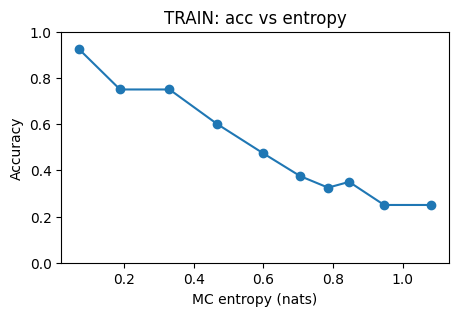

VALID: acc vs entropy [0.8, 0.7, 0.7, 0.55, 0.6, 0.4, 0.45, 0.25, 0.3, 0.25]


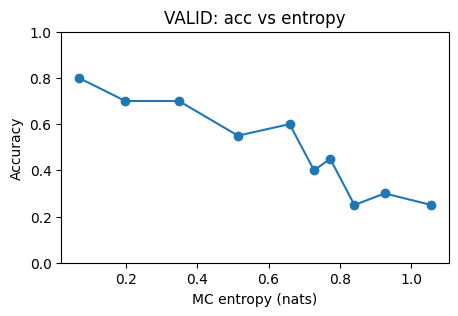

TRAIN: Spearman( -margin , entropy ) = 0.479
VALID: Spearman( -margin , entropy ) = 0.420


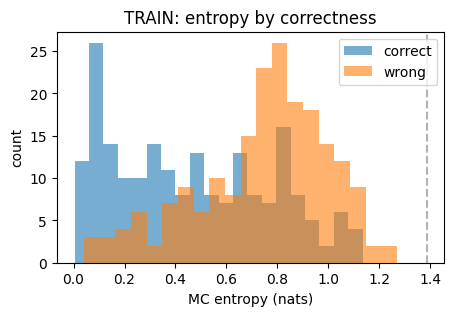

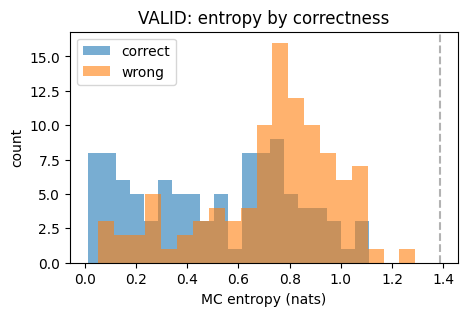

In [56]:
import math, numpy as np
import matplotlib.pyplot as plt

# add multi-choice entropy to existing scored records
def add_entropy_in_place(scored):
    for r in scored:
        lps = letter_logprobs(r["prompt"])               # dict: {'A': lpA, ...}
        r["mc_entropy"] = mc_entropy(lps)                # nats in [0, ln(4)]

add_entropy_in_place(train_scored)
add_entropy_in_place(val_scored)

# Quick sanity: entropy stats for correct vs wrong
def entropy_summary(name, scored):
    corr_H = [r["mc_entropy"] for r in scored if r["is_correct"]==1]
    wrong_H = [r["mc_entropy"] for r in scored if r["is_correct"]==0]
    def stats(xs):
        xs = np.array(xs, float)
        return dict(n=len(xs), mean=xs.mean(), q25=np.quantile(xs,0.25),
                    q50=np.quantile(xs,0.5), q75=np.quantile(xs,0.75))
    print(f"{name}  H(correct): { {k: round(v,3) for k,v in stats(corr_H).items()} }")
    print(f"{name}  H(wrong):   { {k: round(v,3) for k,v in stats(wrong_H).items()} }")

entropy_summary("TRAIN", train_scored)
entropy_summary("VALID", val_scored)

# 2) Accuracy vs entropy (label-free confidence)
def binned_acc_by_entropy(scored, nbins=10, title=""):
    xs = np.array([r["mc_entropy"] for r in scored], float)
    ys = np.array([r["is_correct"]  for r in scored], int)
    edges = np.quantile(xs, np.linspace(0,1,nbins+1))
    mids, accs = [], []
    for i in range(nbins):
        mask = (xs>=edges[i]) & (xs<=edges[i+1] if i==nbins-1 else xs<edges[i+1])
        if mask.sum()>0:
            mids.append(xs[mask].mean()); accs.append(ys[mask].mean())
    print(title, [round(a,2) for a in accs])
    # Optional plot
    try:
        plt.figure(figsize=(5,3))
        plt.plot(mids, accs, marker="o")
        plt.xlabel("MC entropy (nats)"); plt.ylabel("Accuracy")
        plt.ylim(0,1); plt.title(title or "Accuracy vs entropy")
        plt.show()
    except Exception: pass

binned_acc_by_entropy(train_scored, title="TRAIN: acc vs entropy")
binned_acc_by_entropy(val_scored,   title="VALID: acc vs entropy")

# 3) Relation to your log-prob margin (expect negative correlation)
def spearman_no_scipy(a, b):
    ra = np.argsort(np.argsort(a)); rb = np.argsort(np.argsort(b))
    return float(np.corrcoef(ra, rb)[0,1])

def corr_reports(scored, name):
    H = np.array([r["mc_entropy"] for r in scored], float)
    M = np.array([r["logprob_margin"] for r in scored], float)
    # correlate on ALL items; sign should be ~ -1 * monotonic strength
    rho = spearman_no_scipy(H, -M)  # larger (-M) ↔ lower H
    print(f"{name}: Spearman( -margin , entropy ) = {rho:.3f}")

corr_reports(train_scored, "TRAIN")
corr_reports(val_scored,   "VALID")

# 4) Histogram: entropy for correct vs wrong (should separate)
def entropy_hist(scored, title):
    Hc = [r["mc_entropy"] for r in scored if r["is_correct"]==1]
    Hw = [r["mc_entropy"] for r in scored if r["is_correct"]==0]
    try:
        plt.figure(figsize=(5,3))
        plt.hist(Hc, bins=20, alpha=0.6, label="correct")
        plt.hist(Hw, bins=20, alpha=0.6, label="wrong")
        plt.axvline(math.log(4), ls="--", color="gray", alpha=0.6)  # ln(4) max
        plt.title(title); plt.xlabel("MC entropy (nats)"); plt.ylabel("count"); plt.legend(); plt.show()
    except Exception: pass

entropy_hist(train_scored, "TRAIN: entropy by correctness")
entropy_hist(val_scored,   "VALID: entropy by correctness")

# 5) (Optional) Risk–coverage curve using entropy threshold
def risk_coverage(scored, steps=10, start_q=0.0):  # start_q=0.1 if you want to skip ultra-low coverage
    xs = np.array([r["mc_entropy"] for r in scored], float)
    ys = np.array([r["is_correct"] for r in scored], int)
    if xs.size == 0:
        return []
    qs  = np.linspace(start_q, 1.0, steps)         # e.g., [0.0, 0.1, ..., 1.0]
    ths = np.quantile(xs, qs)                      # safe: q=1.0 returns max(xs)
    out = []
    for tau in ths:
        mask = xs <= tau
        cov  = float(mask.mean())
        acc  = float(ys[mask].mean()) if mask.any() else float("nan")
        out.append((float(tau), cov, acc))
    return out